# Heat Equation

Im going to try to implement a PINN for the heat equation using the oscilaltor PINN as template.

The **1D heat equation** describes how heat diffuses through a material (like a metal rod):

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$


Where:
- $u(t, x)$ = temperature at position $x$ and time $t$
- $\alpha$ = thermal diffusivity (how fast heat spreads)

### Key Differences from Harmonic Oscillator:

| Harmonic Oscillator | Heat Equation |
|---------------------|---------------|
| Time only (1D input: $t$) | Time AND space (2D input: $t, x$) |
| $\frac{d^2x}{dt^2} + \mu\frac{dx}{dt} + kx = 0$ | $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$ |
| Second derivative in time | First derivative in time, second in space |

---

**Domain:** 
- Space: $x \in [0, 1]$
- Time: $t \in [0, 1]$

**Initial Condition (IC):** $u(0, x) = \sin(\pi x)$

**Boundary Conditions (BC):** 
- $u(t, 0) = 0$ (left edge always zero)
- $u(t, 1) = 0$ (right edge always zero)

**Analytical Solution:** $u(t, x) = e^{-\alpha \pi^2 t} \sin(\pi x)$

In [21]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

import jax.numpy as jnp

import copy

# Problem parameters
alpha = 0.1
L = 1.0  # length of domain
T = 1.0  # final time

# 1. Initial Condition points (10 points at t=0)
t_ic = jnp.zeros((10, 1))
x_ic = jnp.linspace(0, 1, 10).reshape(-1, 1)
u_ic = jnp.sin(jnp.pi * x_ic)


# 2. Boundary Condition points (20 total: 10 at each edge)
# Left boundary (x=0):
t_bc_left = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_right = jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1))


# 3. Physics collocation points (30×30 = 900 points)
t_vals = jnp.linspace(0, 1, 30)
x_vals = jnp.linspace(0, 1, 30)
T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
t_physics = T_grid.reshape(-1, 1)
x_physics = X_grid.reshape(-1, 1)



# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., [2, 32, 32, 32, 1]
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point, alpha):

    def u(t_val, x_val):
        tx_in = jnp.array([[t_val, x_val]])
        return network(params, tx_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point)

    d2u_dx2 = grad(grad(u, argnums = 1), argnums=1)(t_point, x_point)

    return du_dt - alpha * d2u_dx2
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x) pair, keeping params and alpha fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0, None))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [2, 32, 32, 32, 1]  # 2 inputs (t, x), 1 output (u)
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, u_ic, 
                t_bc, x_bc, u_bc, t_physics, x_physics, alpha):

    def loss_fn(params):
        # 1. Initial Condition Loss
        # Network prediction at IC points
        tx_ic = jnp.concatenate([t_ic, x_ic], axis=1)  # Combine t and x
        u_pred_ic = network(params, tx_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss
        tx_bc = jnp.concatenate([t_bc, x_bc], axis=1)
        u_pred_bc = network(params, tx_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)
        
        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), # (900,) not (900, 1)
                                                x_physics.ravel(), # (900,) not (900, 1)
                                                alpha)
        physics_loss = (1e-2) * jnp.mean(physics_residuals**2) # Physics residual is of 900 points. Much more than our ic and bc points. Therefore we multiply by 1e-4 so it doesn't overpower
        
        return ic_loss + bc_loss + physics_loss
    
        # Compute loss and gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val


# Training parameters
num_iterations = 20000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()

# Training loop
losses = []
for i in range(num_iterations):
    params, opt_state, loss = update_step(
        params, opt_state,
        t_ic, x_ic, u_ic,
        t_bc, x_bc, u_bc,
        t_phys_flat, x_phys_flat,
        alpha
    )
    
    losses.append(loss)


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")





Iteration 1000/20000, Loss: 0.000293
Iteration 2000/20000, Loss: 0.000048
Iteration 3000/20000, Loss: 0.000025
Iteration 4000/20000, Loss: 0.000011
Iteration 5000/20000, Loss: 0.000017
Iteration 6000/20000, Loss: 0.000005
Iteration 7000/20000, Loss: 0.000004
Iteration 8000/20000, Loss: 0.000003
Iteration 9000/20000, Loss: 0.000002
Iteration 10000/20000, Loss: 0.000002
Iteration 11000/20000, Loss: 0.000002
Iteration 12000/20000, Loss: 0.000002
Iteration 13000/20000, Loss: 0.000001
Iteration 14000/20000, Loss: 0.000001
Iteration 15000/20000, Loss: 0.000001
Iteration 16000/20000, Loss: 0.000001
Iteration 17000/20000, Loss: 0.000001
Iteration 18000/20000, Loss: 0.000001
Iteration 19000/20000, Loss: 0.000001
Iteration 20000/20000, Loss: 0.000001


## Plot Results

U_exact shape: (100, 100)
U_pred shape: (100, 100)


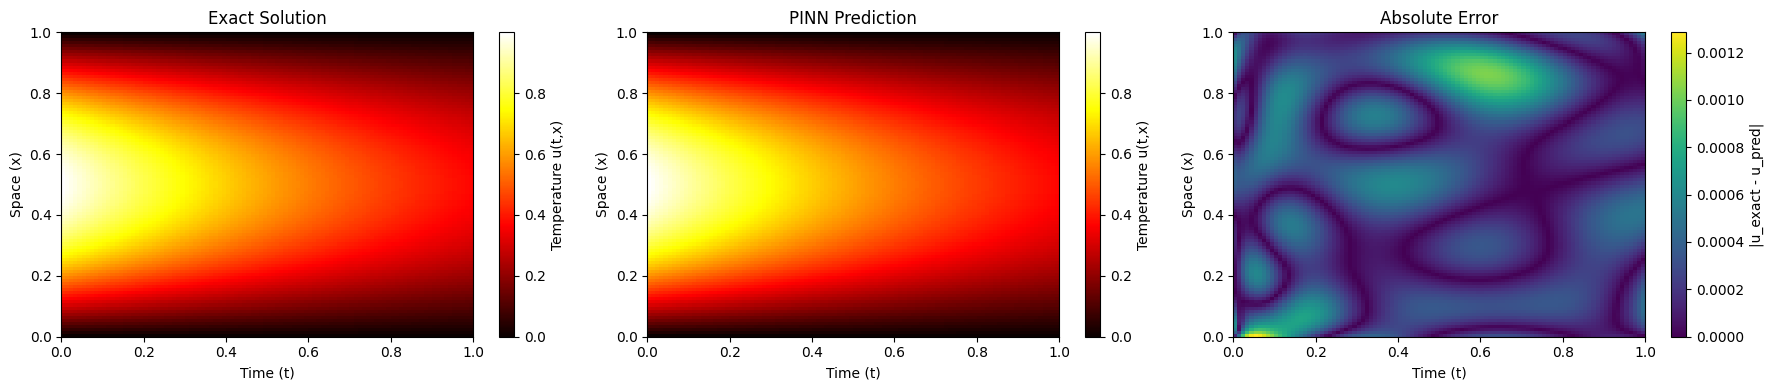


Relative L2 Error: 7.175942e-04


In [22]:
# Generate the analytical solution over a dense grid

# Create dense grid for plotting (100x100 points)
t_plot = jnp.linspace(0, 1, 100)
x_plot = jnp.linspace(0, 1, 100)
T_plot, X_plot = jnp.meshgrid(t_plot, x_plot)

# Analytical solution
U_exact = jnp.exp(-alpha * jnp.pi**2 * T_plot) * jnp.sin(jnp.pi * X_plot)

# Network prediction
TX_plot = jnp.stack([T_plot.ravel(), X_plot.ravel()], axis=1)  # (10000, 2)
U_pred_flat = network(params, TX_plot)
U_pred = U_pred_flat.reshape(100, 100)

print("U_exact shape:", U_exact.shape)
print("U_pred shape:", U_pred.shape)


import matplotlib.pyplot as plt

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Exact solution
im1 = axes[0].imshow(U_exact, extent=[0, 1, 0, 1], origin='lower', 
                     aspect='auto', cmap='hot')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('Space (x)')
axes[0].set_title('Exact Solution')
plt.colorbar(im1, ax=axes[0], label='Temperature u(t,x)')

# Plot 2: PINN prediction
im2 = axes[1].imshow(U_pred, extent=[0, 1, 0, 1], origin='lower',
                     aspect='auto', cmap='hot')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Space (x)')
axes[1].set_title('PINN Prediction')
plt.colorbar(im2, ax=axes[1], label='Temperature u(t,x)')

# Plot 3: Absolute error
error = jnp.abs(U_exact - U_pred)
im3 = axes[2].imshow(error, extent=[0, 1, 0, 1], origin='lower',
                     aspect='auto', cmap='viridis')
axes[2].set_xlabel('Time (t)')
axes[2].set_ylabel('Space (x)')
axes[2].set_title('Absolute Error')
plt.colorbar(im3, ax=axes[2], label='|u_exact - u_pred|')

plt.tight_layout()
plt.savefig('heat_equation_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute relative L2 error
l2_error = jnp.sqrt(jnp.mean((U_exact - U_pred)**2)) / jnp.sqrt(jnp.mean(U_exact**2))
print(f"\nRelative L2 Error: {l2_error:.6e}")

In [23]:
# Check decay at center point x=0.5
x_center = 0.5
t_values = jnp.array([0.0, 0.5, 1.0])

print("\nTemperature at x=0.5 (center) over time:")
print("-" * 50)
for t_val in t_values:
    # Exact solution
    u_exact_val = jnp.exp(-alpha * jnp.pi**2 * t_val) * jnp.sin(jnp.pi * x_center)
    
    # PINN prediction
    tx_point = jnp.array([[t_val, x_center]])
    u_pred_val = network(params, tx_point)[0, 0]
    
    print(f"t={t_val:.1f}: Exact={u_exact_val:.6f}, PINN={u_pred_val:.6f}, Diff={abs(u_exact_val - u_pred_val):.6f}")


Temperature at x=0.5 (center) over time:
--------------------------------------------------
t=0.0: Exact=1.000000, PINN=0.999613, Diff=0.000387
t=0.5: Exact=0.610498, PINN=0.610034, Diff=0.000464
t=1.0: Exact=0.372708, PINN=0.372413, Diff=0.000295


### Plot Temperature Against x at different time frames

In [24]:
import matplotlib.pyplot as plt
import os

# Create directory for frames
os.makedirs('frames', exist_ok=True)

def plot_snapshot(params_snapshot, iteration, alpha):
    """Plot predicted vs exact at 4 time slices"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    time_slices = [0.0, 0.33, 0.67, 1.0]
    x_vals = jnp.linspace(0, 1, 100)
    
    for idx, t_val in enumerate(time_slices):
        ax = axes[idx]
        
        # Exact solution
        u_exact = jnp.exp(-alpha * jnp.pi**2 * t_val) * jnp.sin(jnp.pi * x_vals)
        
        # PINN prediction
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params_snapshot, tx_input).ravel()
        
        # Plot
        ax.plot(x_vals, u_exact, 'b-', linewidth=2, label='Exact', alpha=0.8)
        ax.plot(x_vals, u_pred, 'r--', linewidth=2, label='PINN', alpha=0.8)
        ax.set_xlabel('Space (x)', fontsize=11)
        ax.set_ylabel('Temperature u(t,x)', fontsize=11)
        ax.set_title(f't = {t_val:.2f}', fontsize=12)
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    
    plt.suptitle(f'Training Step: {iteration}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames from snapshots
print("Generating frames...")
files = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_snapshot(params_snap, iteration, alpha)
    files.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal frames: {len(files)}")

# Create GIF
from PIL import Image

def save_gif_PIL(outfile, files, fps=10, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

print("Creating GIF...")
save_gif_PIL("heat_pinn_learning.gif", files, fps=10, loop=0)
print("Done! Check heat_pinn_learning.gif")

Generating frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total frames: 133
Creating GIF...
Done! Check heat_pinn_learning.gif


### Plot Temperature Against t at different positions

In [25]:
def plot_temperature_vs_time(params_snapshot, iteration, alpha):
    """Plot u vs t at 4 different spatial positions"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    x_positions = [0.25, 0.4, 0.6, 0.75]  # 4 different positions
    t_vals = jnp.linspace(0, 1, 100)
    
    for idx, x_val in enumerate(x_positions):
        ax = axes[idx]
        
        # Exact solution
        u_exact = jnp.exp(-alpha * jnp.pi**2 * t_vals) * jnp.sin(jnp.pi * x_val)
        
        # PINN prediction
        x_vals = jnp.full_like(t_vals, x_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params_snapshot, tx_input).ravel()
        
        # Plot
        ax.plot(t_vals, u_exact, 'b-', linewidth=2, label='Exact', alpha=0.8)
        ax.plot(t_vals, u_pred, 'r--', linewidth=2, label='PINN', alpha=0.8)
        ax.set_xlabel('Time (t)', fontsize=11)
        ax.set_ylabel('Temperature u(t,x)', fontsize=11)
        ax.set_title(f'x = {x_val:.2f}', fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    
    plt.suptitle(f'Training Step: {iteration}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames_time/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename


# Create directory
os.makedirs('frames_time', exist_ok=True)

# Generate frames
print("Generating temperature vs time frames...")
files = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_temperature_vs_time(params_snap, iteration, alpha)
    files.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

# Create GIF
save_gif_PIL("heat_pinn_time_evolution.gif", files, fps=10, loop=0)
print("Done! Check heat_pinn_time_evolution.gif")

Generating temperature vs time frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames
Done! Check heat_pinn_time_evolution.gif


### 3D Visualization

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Create directory
os.makedirs('frames_3d', exist_ok=True)

def plot_3d_surface(params_snapshot, iteration, alpha):
    """Plot 3D surface of u(t, x)"""
    fig = plt.figure(figsize=(16, 6))
    
    # Create grid
    t_vals = jnp.linspace(0, 1, 50)
    x_vals = jnp.linspace(0, 1, 50)
    T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
    
    # Exact solution
    U_exact = jnp.exp(-alpha * jnp.pi**2 * T_grid) * jnp.sin(jnp.pi * X_grid)
    
    # PINN prediction
    TX_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred_flat = network(params_snapshot, TX_flat)
    U_pred = U_pred_flat.reshape(50, 50)
    
    # Plot exact solution
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(T_grid, X_grid, U_exact, cmap='hot', 
                             alpha=0.9, edgecolor='none')
    ax1.set_xlabel('Time (t)', fontsize=10)
    ax1.set_ylabel('Space (x)', fontsize=10)
    ax1.set_zlabel('Temperature u', fontsize=10)
    ax1.set_title('Exact Solution', fontsize=12)
    ax1.set_zlim(0, 1.0)
    ax1.view_init(elev=25, azim=45)  # Set viewing angle
    
    # Plot PINN prediction
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(T_grid, X_grid, U_pred, cmap='hot', 
                             alpha=0.9, edgecolor='none')
    ax2.set_xlabel('Time (t)', fontsize=10)
    ax2.set_ylabel('Space (x)', fontsize=10)
    ax2.set_zlabel('Temperature u', fontsize=10)
    ax2.set_title('PINN Prediction', fontsize=12)
    ax2.set_zlim(0, 1.0)
    ax2.view_init(elev=25, azim=45)  # Match viewing angle
    
    plt.suptitle(f'Training Step: {iteration}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames_3d/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames
print("Generating 3D surface frames...")
files_3d = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_3d_surface(params_snap, iteration, alpha)
    files_3d.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal 3D frames: {len(files_3d)}")

# Create GIF
print("Creating 3D GIF...")
save_gif_PIL("heat_pinn_3d_learning.gif", files_3d, fps=10, loop=0)
print("Done! Check heat_pinn_3d_learning.gif")

Generating 3D surface frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total 3D frames: 133
Creating 3D GIF...
Done! Check heat_pinn_3d_learning.gif


# Doubts

**Excellent questions!** Let me clarify both:

---

## Q18: The `@` Symbol - Python Decorators

The `@` is a **decorator** - it's syntactic sugar that wraps a function.

These two are **equivalent**:

```python
# With decorator
@jit
def update_step(...):
    ...
```

```python
# Without decorator (what's actually happening)
def update_step(...):
    ...
update_step = jit(update_step)  # Wrap the function with jit
```

**What `@jit` does:**
1. First call: JAX **traces** the function (records operations) and **compiles** it to optimized machine code (XLA)
2. Subsequent calls: Runs the **pre-compiled** version (100-200x faster!)

**Think of it like:** 
- No `@jit`: Python interpreter reads your code line-by-line every time (slow)
- With `@jit`: First time takes ~2 seconds to compile, then runs super fast forever

**Other common decorators:**
- `@property` - Makes a method act like an attribute
- `@staticmethod` - Method that doesn't need `self`
- `@jit` - Compile for speed

---

## Q19: Separate Arrays for Physics Points

**Exactly right!** ✅✅✅

Let me visualize what vmap does:

```python
physics_residual_batch = vmap(physics_residual_single, 
                               in_axes=(None, 0, 0, None))
```

**Input arrays:**
```
t_phys.ravel() = [t₁, t₂, t₃, ..., t₉₀₀]  # shape (900,)
x_phys.ravel() = [x₁, x₂, x₃, ..., x₉₀₀]  # shape (900,)
```

**What vmap does (conceptually):**
```python
results = []
for i in range(900):
    res = physics_residual_single(params, t_phys[i], x_phys[i], alpha)
    results.append(res)
```

So each call gets:
- Call 1: `physics_residual_single(params, t₁, x₁, alpha)`
- Call 2: `physics_residual_single(params, t₂, x₂, alpha)`
- Call 3: `physics_residual_single(params, t₃, x₃, alpha)`
- ...

## One Small Note:

In the `update_step` function, you need to pass **raveled** arrays to `physics_residual_batch`:

```python
physics_res = physics_residual_batch(p, 
                                     t_phys.ravel(),  # (900,) not (900, 1)
                                     x_phys.ravel(),  # (900,) not (900, 1)
                                     alpha)
```

The `.ravel()` flattens (900, 1) → (900,) which vmap expects for `in_axes=0`.

---
